# Wide&Deep两个优化器分别优化

1.对于wide部分训练时候使用的优化器是带$L1$正则的FTRL算法(Follow-the-regularized-leader)，而$L1$的FTLR是非常注重模型稀疏性质的，也就是说W&D模型采用$L1$ FTRL是想让Wide部分变得更加的稀疏，即Wide部分的大部分参数都为0，这就大大压缩了模型权重及特征向量的维度。Wide部分模型训练完之后留下来的特征都是非常重要的，那么模型的“记忆能力”就可以理解为发现"直接的"，“暴力的”，“显然的”关联规则的能力。<br>
2.DNN模型随着层数的增加，中间的特征就越抽象，也就提高了模型的泛化能力。 对于Deep部分的DNN模型使用了深度学习常用的优化器AdaGrad，这也是为了使得模型可以得到更精确的解。

# L1正则化&L2正则化

对于L2正则化：$𝐶=𝐶_0+\frac{\lambda}{2𝑛}∑_𝑖{𝜔_i}^2$，相比于未加正则化之前,权重的偏导多了一项$\frac{\lambda}{𝑛}w$,梯度更新变为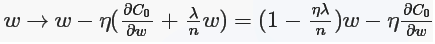
可以看出𝜔的系数使得权重下降加速，因此L2正则也称weight decay

对于L1正则化：$𝐶=𝐶_0+\frac{\lambda}{𝑛}∑_𝑖{\|𝜔_i\|}$，梯度下降的更新为：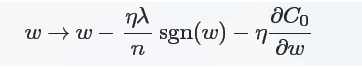
符号函数在𝜔大于0时为1，小于0时为-1，在𝜔=0时|𝜔|没有导数，因此可令sgn(0)=0，在0处不使用L1正则化

L1相比于L2，有所不同：
L1减少的是一个常量，L2减少的是权重的固定比例
孰快孰慢取决于权重本身的大小，权重刚大时可能L2快，较小时L1快
L1使权重稀疏，L2使权重平滑，一句话总结就是：L1会趋向于产生少量的特征，而其他的特征都是0，而L2会选择更多的特征，这些特征都会接近于0

# Lambda MART

lambda：大师强制定义的梯度。含义是：指明下一次移动的方向和强度。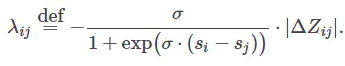

公式第一部分，是ranknet损失函数第一部分梯度<br>
$query-url$的相关性是一个分数来度量。 $score(q-u1) > score(q-u2)$ ,则q下，u1的相关性大于u2.<br>
没有去学习单个文档的相关性，而是比较两个文档的相关性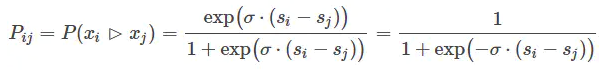
有了这个公式，我们就能量化，两个不同文档的，相比较下相关性强弱。<br>
我们无非就是学 $P_{ij}$， 使其与真时的$label$一致。 那么这里我们用交叉熵损失函数优化<br>
ranknet是想做的是让不同的结果打出不同的分数，不同的分数可以比较相关性强弱就行，我比你强，那么我的分数就要比你大 ，哪怕只是大一点点点点都行。那么在这种情况下，我们在理解下ranknet的损失函数，他并不关心线上的顺序，他只是给每个结果算出仅仅能够表示强弱的分数即可，只要能让损失降调最小。
ranknet的损失函数，优点是通过降低损失减少逆序对，缺点是调序的盲目性，未考虑到topk的相关性逐渐减弱。

DCG指标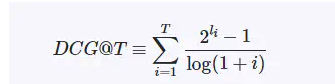 <br>
 1. 每次迭代都会算出的$lambda * ndcg$，表示 调整每个结果所带来的对梯度下降的影响以及对整体的影响<br>
 2. 基于算出的梯度值y值，我们接下来会用树进行拟合，实际上这个过程就将梯度值差不多的样本放到了同一个叶子节点上。 基于算出的梯度值y值，我们接下来会用树进行拟合，实际上这个过程就将梯度值差不多的样本放到了同一个叶子节点上。
 3. 而loss下降贡献越大，也就是某个叶子节点上的整体值越大，表示这个样本越相关，因为对调序带来的影响越大
 4. 特征好坏，主表现在能否将不同级别的相关性结果，分别放到自己级别对应的相关性节点上，如果能放到，那么这个节点的输出值（如平均值），则更能代表这个级别的相关性值。那么最后梯度就会降的更低（因为叶子节点上的每个值大小都差不多，所以损失误差就最小）。而不好的特征，则分不开
 5. 每个样本计算lambda 或者 ndcg的变化，是将上一轮树中叶子节点中属于该query的所有结果，组成list计算的， 计算后的值就是新的梯度，作为下一轮训练树该样本的y值。而每轮训练回归树的时候，是跨query的，将所有的样本按照特征分裂到不同的树。当迭代数轮后，每个叶子节点都有属于不同query的样本，分到同一个叶子节点，同一个query下的url，其相关性是相同的。

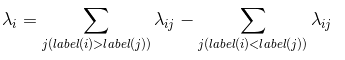<br>
上表中每一列都是考虑了符号的$lamda(i,j)$，即如果$label(i)<label(j)$，则为负值，反之为正值，每行结尾的$lamda(i)$是前面的加和，即为最终的$lambda(i)$。
可以看到，$lambda(i)$在系统中表达了$doc(i)$上升或者下降的强度，label越高，位置越后，$lambda(i)$为正值，越大，表示趋向上升的方向，力度也越大；label越小，位置越靠前，$lambda(i)$为负值，越小，表示趋向下降的方向，力度也大（lambda(i)的绝对值表达了力度。

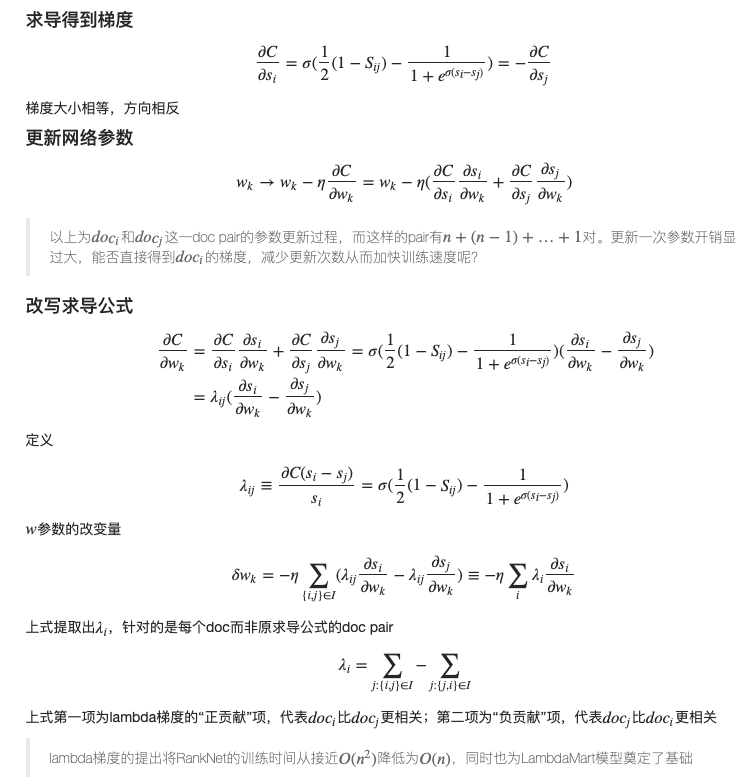

# 为什么均方差（MSE）不适合分类问题？交叉熵（cross-entropy）不适合回归问题？

1. 在使用MSE时，w、b的梯度均与sigmoid函数对z的偏导有关系，而sigmoid函数的偏导在自变量非常大或者非常小时，偏导数的值接近于零，这将导致w、b的梯度将不会变化，也就是出现所谓的梯度消失现象。而使用cross-entropy时，w、b的梯度就不会出现上述的情况。所以MSE不适用于分类问题。<br>
2. 当MSE和交叉熵同时应用到多分类场景下时，（标签的值为1时表示属于此分类，标签值为0时表示不属于此分类），MSE对于每一个输出的结果都非常看重，而交叉熵只对正确分类的结果看重。交叉熵的损失函数只和分类正确的预测结果有关系，而MSE的损失函数还和错误的分类有关系，该分类函数除了让正确的分类尽量变大，还会让错误的分类变得平均，但实际在分类问题中这个调整是没有必要的。但是对于回归问题来说，这样的考虑就显得很重要了。所以，回归问题熵使用交叉上并不合适。

# word2vec中的负采样与分层softmax

分层softmax(Hierachical Softmax)思想：<br>
Hierachical Softmax的基本思想就是首先将词典中的每个词按照词频大小构建出一棵Huffman树，保证词频较大的词处于相对比较浅的层，词频较低的词相应的处于Huffman树较深层的叶子节点，每一个词都处于这棵Huffman树上的某个叶子节点；第二，将原本的一个|V|分类问题变成了$logV$次的二分类问题，做法简单说来就是，原先要计算$P$的时候，因为使用的是普通的softmax，势必要求词典中的每一个词的概率大小，为了减少这一步的计算量，在Hierachical Softmax中，同样是计算当前词$w$在其上下文中的概率大小，只需要把它变成在Huffman树中的路径预测问题就可以了，因为当前词$w$在Huffman树中对应到一条路径，这条路径由这棵二叉树中从根节点开始，经过一系列中间的父节点，最终到达当前这个词的叶子节点而组成，那么在每一个父节点上，都对应的是一个二分类问题（本质上就是一个LR分类器），而Huffman树的构造过程保证了树的深度为$logV$，所以也就只需要做$logV$次二分类便可以求得$p$的大小，这相比原来|V|次的计算量，已经大大减小了。

# BN

因为深层神经网络在做非线性变换前的激活输入值（就是那个x=WU+B，U是输入）随着网络深度加深或者在训练过程中，其分布逐渐发生偏移或者变动，之所以训练收敛慢，一般是整体分布逐渐往非线性函数的取值区间的上下限两端靠近（对于Sigmoid函数来说，意味着激活输入值WU+B是大的负值或正值），所以这导致反向传播时低层神经网络的梯度消失，这是训练深层神经网络收敛越来越慢的本质原因，而BN就是通过一定的规范化手段，把每层神经网络任意神经元这个输入值的分布强行拉回到均值为0方差为1的标准正态分布，其实就是把越来越偏的分布强制拉回比较标准的分布，这样使得激活输入值落在非线性函数对输入比较敏感的区域，这样输入的小变化就会导致损失函数较大的变化，意思是这样让梯度变大，避免梯度消失问题产生，而且梯度变大意味着学习收敛速度快，能大大加快训练速度。

# 模型压缩

1. 模型剪枝<br>
是贪心法，或称为saliency-based方法。即按重要性排序，然后将不重要的部分去除。然而问题来了，就是重要性如何衡量。<br>
(1) 一个最简单的启发就是按参数（或特征输出）绝对值大小来评估重要性，然后用贪心法将那部分干掉，在训练时加入L1正则化，使权重稀疏，在BN层加入channel-wise scaling factor 并对之加L1 regularizer使之稀疏<br>
(2) 考虑参数裁剪对loss的影响。
(3) 考虑对特征输出的可重建性的影响，即最小化裁剪后网络对于特征输出的重建误差。它的intuition是如果对当前层进行裁剪，然后如果它对后面输出还没啥影响，那说明裁掉的是不太重要的信息
(4) 贪心算法的缺点就是只能找到局部最优解，因为它忽略了参数间的相互关系。那自然肯定会有一些方法会尝试考虑参数间的相互关系，试图找导全局更优解。
2. 模型量化，权值共享<br>
对量化的实现是通过把常见操作转换为等价的八位版本达到的，涉及的操作包括卷积，矩阵乘法，激活函数，池化操作，以及拼接，将input从浮点数转换成8 bit，再把output从8 bit转回浮点数。模型大小减少1/4，quantize取input中的min和max，分别对应被量化的input中的最小值（0）和最大值（255），把[min, max]这个区间均匀分成255个小区间，把input中的值对应到对应的区间中。反量化操作则是把上述操作反向执行，原来的256个值，每个是8bit，那么一共需要2048个字节才能把数据全都记下来。而用了新方法后，每个值都可以表示为3bit的中心点和2bit的偏移量的大小，那么就变成了5bit来表示一个数字，一共需要1280的字节就够了。<br>
数据重复越多，熵越低，哈夫曼编码就越能用短的码值来表示更多的数字，编码的效率就越高，压缩的效果就越好。
3. 模型蒸馏<br>
基于教师——学生网络的方法，属于迁移学习的一种。迁移学习也就是将一个模型的性能迁移到另一个模型上，而对于教师——学生网络，教师网络往往是一个更加复杂的网络，具有非常好的性能和泛化能力，可以用这个网络来作为一个soft target来指导另外一个更加简单的学生网络来学习，使得更加简单、参数运算量更少的学生模型也能够具有和教师网络相近的性能<br>
基于精细模型设计的方法,例如小卷机的运用两个3*3的卷积效果等于一个5*5，但是参数量减少7，1*1的卷积减少通道

# ESMM

有效解决了真实场景中CVR预估面临的数据稀疏以及样本选择偏差这两个关键问题<br>
CVR预估模型的本质，不是预测“item被点击，然后被转化”的概率（CTCVR），而是“假设item被点击，那么它被转化”的概率（CVR）<br>
点击（CTR）、转化（CVR）、点击然后转化（CTCVR）三者的关联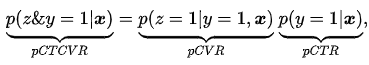
ESMM通过学习CTR和CTCVR，隐式的学习CVR，注意不能分开学习CTR和CTCVR，然后用$pCVR = pCTCVR/pCTR$,真实场景预测出来的pCTR、pCTCVR值都比较小，“除”的方式容易造成数值上的不稳定

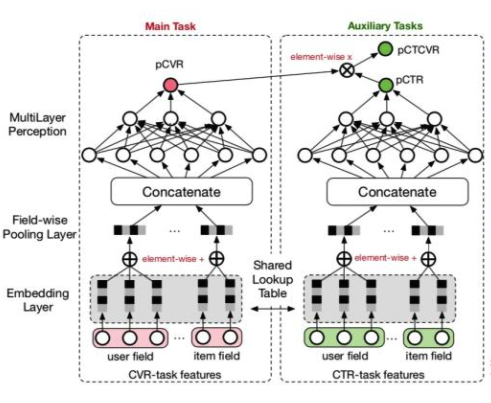CVR是网络中的一个variable，没有对它直接建模

损失函数为两部分构成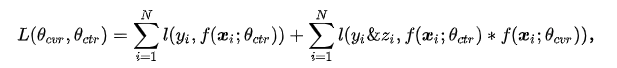

# XGB不适用于ID类的特征

1. 在类别数不是太大时，可以用one-hot
2. 将类别特征做成有序类别特征会增加模型的学习难度
3. 数模型没有统一的规则来解决类别型特征，擅长的是有序模型
4. 可以于训练逻辑回归模型，对每个特征的取值做一个重要性排序，删除想关性小的特征

# 连续特征离散化

1. 离散特征的增加和减少都很容易，易于模型的快速迭代；
2. 稀疏向量内积乘法运算速度快，计算结果方便存储，容易扩展；
3. 离散化后的特征对异常数据有很强的鲁棒性：比如一个特征是年龄>30是1，否则0。如果特征没有离散化，一个异常数据“年龄300岁”会给模型造成很大的干扰；
4. 逻辑回归属于广义线性模型，表达能力受限；单变量离散化为N个后，每个变量有单独的权重，相当于为模型引入了非线性，能够提升模型表达能力，加大拟合；
5. 离散化后可以进行特征交叉，由M+N个变量变为M*N个变量，进一步引入非线性，提升表达能力；
6. 特征离散化后，模型会更稳定，比如如果对用户年龄离散化，20-30作为一个区间，不会因为一个用户年龄长了一岁就变成一个完全不同的人。当然处于区间相邻处的样本会刚好相反，所以怎么划分区间是门学问；
7. 特征离散化以后，起到了简化了逻辑回归模型的作用，降低了模型过拟合的风险。

# 负样本采样思路

1. 在任何一个推荐系统中，“八二定律”都是不可避免的，也就是少数热门物料占据了绝大多数的曝光与点击
2. 这样一来，正样本被少数热门物料所绑架，导致所有人的召回结果都集中于少数热门物料，完全失去了个性化。
3. 因此，当热门物料做正样本时，要降采样，减少对正样本集的绑架。比如，某物料成为正样本的概率如下，其中z(wi)是第i个物料的曝光或点击占比，打压正样本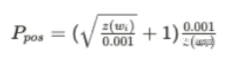

4. 当热门物料做负样本时，要适当过采样，抵销热门物料对正样本集的绑架；同时，也要保证冷门物料在负样本集中有出现的机会。比如，某物料成为负样本的概率如下，其中n(w)是第i个物料的出现次数，而一般取0.75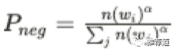

# 挖掘Hard Negative增强样本

1. 匹配度最高的，是以用户点击为代表的，那是正样本。
2. 匹配度最低的，那是随机抽取的。能被一眼看穿，没难度，所谓的easy negative，达不到锻炼模型的目的
3. 所以要选取一部分匹配度适中的，能够增加模型在训练时的难度，让模型能够关注细节，这就是所谓的hard negative。

增加与正样本同城的房间作为负样本，增强了正负样本在地域上的相似性，加大了模型的学习难度<br>
增加“被房主拒绝”作为负样本，增强了正负样本在“匹配用户兴趣爱好”上的相似性，加大了模型的学习难度

# FM召回思路

FM召回的主流作法，是用生成的user embedding直接查找最相近的item embedding。除此之外，利用已经生成了的user/item embedding，还有更多的玩法，比如，查找相似item的“看了又看”功能、用户聚类推荐功能、根据item找潜在用户的Push功能。而且，FM对新用户、新物料也非常友好。实现一个FM召回，就能够完成u2i, i2i, i2u, u2u2i四种召回方式，还包括对新用户、新物料的冷启动。性价比如此之高，即使在很多大厂，FM也是主力召回模型，果然是很香了

用完整的FM公式来描述User与Item之间的匹配度。但是，在线上服务时，我们必须将匹配度描述成点积或cosine的形式，才能利用FAISS完成在百万、千万级物料库中的快速召回。这个"FM→点积"的公式转化如下图所示。
1. 当为一个用户召回时，这个用户的一阶权重和特征隐向量都是固定的，因此从公式中省略"所有User特征一阶权重之和"和“所有User特征隐向量两两点积之和”（图中绿色公式）也不影响排序
2. 所有User特征与所有Item特征之间的两两点积之和（第一行红色公式），等价于，将所有User特征embedding相加得到user embedding，将所有Item特征embedding相加得到item embedding，再拿user embedding与item embedding做点积（第二行红色公式）
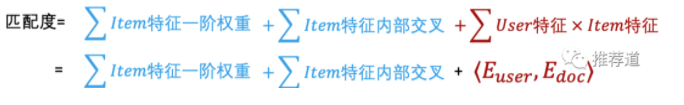

只保留user embedding与item embedding的点积。这样做，也不是不行，但是效果不是特别好。因为用户喜欢的，未必一定是与自身最匹配的，也包括一些自身性质极佳的item（e.g.,热门item），所以，非常有必要将"所有Item特征一阶权重之和"和“所有Item特征隐向量两两点积之和”考虑进去，但是也还必须写成点积的形式

解决方法是将user/item embedding都增广一维，如下图公式所示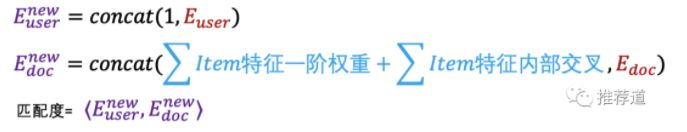

离线
1. 针对每个候选item，提取其所有特征的一阶权重w和隐向量v，计算
2. 将所有item embedding灌入FAISS建立索引。
在线
1. 用户请求到来时，提取其所有特征的隐向量v